<a href="https://colab.research.google.com/github/TiredCat388/CMSC-173-Midterm-Exam/blob/main/CMSC_173_Midterm_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
You are tasked with performing a full data audit and building a robust analytical pipeline. Your final
report should be presented to the lead researchers, who are not data scientists. Your dataset is unique
to you and is located in your exam folder as exam data `202211342.csv.`
#Deliverables
1. Data Quality Audit: A thorough analysis of your data’s issues. Identify and document different
types of errors (e.g., random vs. systematic noise, invalid data formats, logical inconsistencies).

2. Data Cleaning & Preprocessing Strategy: A detailed description of your cleaning method-
ology. Justify your choices. Why did you choose one imputation method over another? How did you handle outliers?

3. Operational Status Prediction: Develop a model to predict the operational status of a panel
(Target Category). Explain your choice of model and evaluate its performance using appropriate
metrics.

4. Energy Output Analysis: Analyze the factors that influence the panel’s energy output (Target Value).
What are the most important predictors? Are there any surprising correlations?
5. Panel Segmentation: Identify and describe any natural groupings of panels in your data. Do
these groups correspond to the different operational statuses or reveal anything about the data
collection issues?
# Key Guiding Questions
- How can you differentiate between random noise and systematic errors that might be present in
your data?
- Is there a discernible pattern in the missing values? What might this imply about the data collection
process?
- The Aux Reading is from a newer, more reliable sensor. How could you leverage this to validate or
correct other readings?
- Some X Coord and Y Coord values appear to be in an unusual format (e.g., hexadecimal strings).
What could this mean, and how should you handle it?
- Do the relationships between the sensor readings and the energy output change for different oper-
ational statuses?
- Are there any distinct groups of panels that might correspond to the different data collection teams
or equipment faults? How would you go about identifying them?

## Setup and Imports

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Explainability
try:
  import shap
except Exception:
  shap = None

# Utility
import joblib
from collections import Counter

## Mounting gitHub / Configuration & Load Data

In [2]:
!git clone https://github.com/TiredCat388/CMSC-173-Midterm-Exam.git

Cloning into 'CMSC-173-Midterm-Exam'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.55 MiB | 8.51 MiB/s, done.
Resolving deltas: 100% (2/2), done.


Load / Testing Data

In [3]:
%cd /content/CMSC-173-Midterm-Exam/Resources/
DATA_PATH = 'exam_data_202211342.csv'
RANDOM_STATE = 42

# Load
df = pd.read_csv(DATA_PATH)

# Quick checks
print('Shape:', df.shape)
df.head()

/content/CMSC-173-Midterm-Exam/Resources
Shape: (14831, 9)


,Measurement_Gamma_0,Value_Alpha_1,Measurement_Beta_2,Reading_Theta_3,X_Coord,Y_Coord,Aux_Reading,Target_Value,Target_Category
0,0.7806350050703716,NaN,3Ar@jt7j**S']c>B_NnbMGYP!,NaN,NaN,NaN,NaN,-2.987661,2
1,9.350014516969022,NaN,-4.703355632591949,NaN,NaN,NaN,NaN,-14.359976,0
2,6.269665852542947,NaN,"wq0Puq""(~@1KEKBdc8S*=",NaN,Ct9*zYn1N5jr+no`D'=,NaN,NaN,-12.397056,0
3,11.474605506223732,NaN,2.4399419255525014,NaN,NaN,NaN,NaN,-4.264666,2
4,7.901331362108691,NaN,-0.45869706833604185,NaN,NaN,NaN,NaN,-24.212789,0


## Quick EDA: DataTypes, missingness, basic stats
- Define rules for corruption per column (numeric regex, hex pattern for coordinates, etc.)
- Generate a corruption mask and sample rows
- Produce a small table summarizing corruption types and counts

In [4]:
# Basic checks
print('\n--- DataTypes ---')
print(df.dtypes)

print('\n--- Describe ---')
display(df.describe(include='all'))

# Missingness overview
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
print(f'Overall missing percent: {missing_percent:.2f}%')
print('\nMissing per column:')
print(missing_counts.sort_values(ascending=False))
print('\nTotal Missing:')
print(sum(missing_counts))


--- DataTypes ---
Measurement_Gamma_0     object
Value_Alpha_1           object
Measurement_Beta_2      object
Reading_Theta_3         object
X_Coord                 object
Y_Coord                 object
Aux_Reading             object
Target_Value           float64
Target_Category          int64
dtype: object

--- Describe ---


,Measurement_Gamma_0,Value_Alpha_1,Measurement_Beta_2,Reading_Theta_3,X_Coord,Y_Coord,Aux_Reading,Target_Value,Target_Category
count,14831,14186,14831,14353,13186,14173,14306,14831.000000,14831.000000
unique,14831,14186,14831,14353,13186,14173,14306,NaN,NaN
top,3.553245910074268,0.17538140693263987,-1.0189229741493784,-1.2880834877488352,8.497505291081051,-3.301598818474657,2.169902929050579,NaN,NaN
freq,1,1,1,1,1,1,1,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.522193,1.000000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.822721,0.816552
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-114.809772,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.670228,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.003018,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.550048,2.000000


Overall missing percent: 2.96%

Missing per column:
X_Coord                1645
Y_Coord                 658
Value_Alpha_1           645
Aux_Reading             525
Reading_Theta_3         478
Measurement_Gamma_0       0
Measurement_Beta_2        0
Target_Value              0
Target_Category           0
dtype: int64

Total Missing:
3951


## Data Quality Audit — detect corrupted cells & unusual formats

- Identify missing values, corrupted cells, inconsistent formats.
- Random vs systematic noise analysis.
- Markdown tables to summarize corruption and missingness.

In [5]:
import re

NUMERIC_COLS = ['Measurement_Gamma_0', 'Value_Alpha_1', 'Measurement_Beta_2', 'Aux_Reading', 'Target_Value']
COORD_COLS = ['X_Coord', 'Y_Coord']
TARGET_CAT = 'Target_Category'
TARGET_VAL = 'Target_Value'

# Helper functions
num_re = re.compile(r'^-?\d+(?:\.\d+)?$')
hex_re = re.compile(r'^(0x)?[0-9A-Fa-f]+$')

corruption_report = {}
corruption_mask = pd.DataFrame(False, index=df.index, columns=df.columns)

for col in df.columns:
  corrupted = 0
  samples = []
  for i, val in enumerate(df[col].astype(str)):
    v = val.strip()
    if v.lower() in ['nan', 'none', 'na', '']:
      continue
    if col in NUMERIC_COLS:
      if not num_re.match(v):
        corrupted += 1
        corruption_mask.at[i, col] = True
        if len(samples) < 5:
          samples.append(v)
    elif col in COORD_COLS:
      if not hex_re.match(v) and not num_re.match(v):
        corrupted += 1
        corruption_mask.at[i, col] = True
        if len(samples) < 5:
          samples.append(v)
    else:
    # generic: consider non-empty strings fine; you may add more rules
      pass
  corruption_report[col] = {'corrupted_count': corrupted, 'examples': samples}


# Show report
rep_df = pd.DataFrame.from_dict(corruption_report, orient='index')
rep_df


# Show sample corrupted rows
sample_corrupted_rows = df[corruption_mask.any(axis=1)].head(10)
sample_corrupted_rows

,Measurement_Gamma_0,Value_Alpha_1,Measurement_Beta_2,Reading_Theta_3,X_Coord,Y_Coord,Aux_Reading,Target_Value,Target_Category
0,0.7806350050703716,NaN,3Ar@jt7j**S']c>B_NnbMGYP!,NaN,NaN,NaN,NaN,-2.987661,2
2,6.269665852542947,NaN,"wq0Puq""(~@1KEKBdc8S*=",NaN,Ct9*zYn1N5jr+no`D'=,NaN,NaN,-12.397056,0
12,8.458874619009517,NaN,-1.06596719754955,NaN,"N3ZuV~t0a^""fWuJtltk{^|}",NaN,NaN,-14.290707,0
25,6.946295664479654,NaN,-1.0569931314471308,NaN,<g{SBR3N+T1#/re~jZq}xDTPW,NaN,NaN,-13.860771,0
26,3.639888902380599,NaN,-2.3153195531908373,NaN,s^beBqS2/TuH%DY!,NaN,NaN,1.868169,2
32,7.937988454928148,NaN,1.0639330195315608,NaN,NaN,NaN,A}|X2m1qL)CSA3`6B{sj!<+U,-12.027286,0
38,8.098070832650901,NaN,-0.8797489180376576,NaN,e?nGsHJ4dWSTB%#8p5->K@yV\,NaN,NaN,-8.008864,1
42,7.0443967190917816,NaN,-4.537104456129492,NaN,NaN,7Q}&E7f){I_Md'%x%@Qsw[c&,NaN,-7.724249,1
45,4.448308313278786,NaN,-3.4749315485910075,NaN,s#l_i*\y[?^*(|j!^9W!,NaN,NaN,-10.303889,1
52,p#&6j}#jFrWv~{eq,]hQDwM&[ZeQ~QZ-,-2.8092583099004735,NaN,NaN,NaN,NaN,-9.551338,1


## Visualize missingness & corruption patterns
- Use a heatmap to visualize patterns
- Check whether missingness / corruption correlates with Target Category or other columns

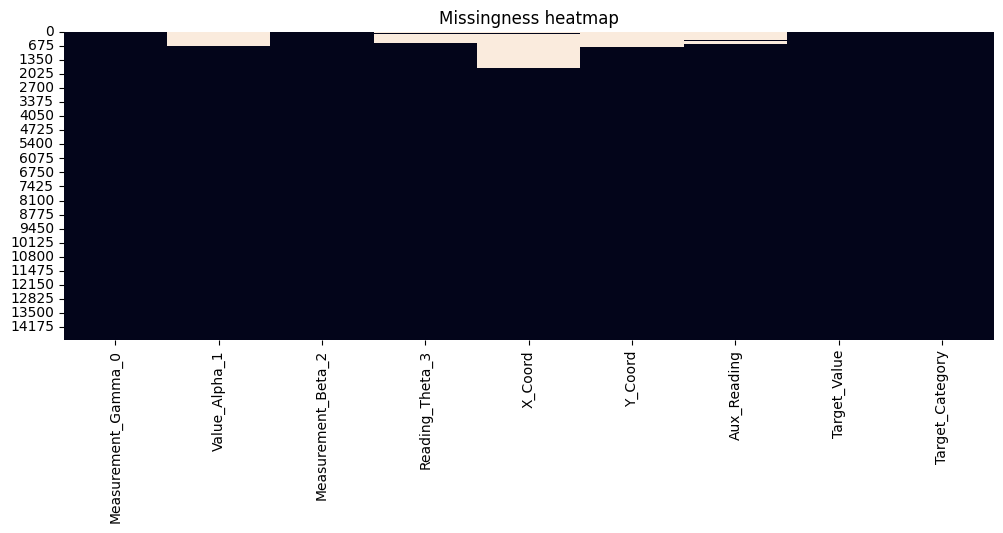

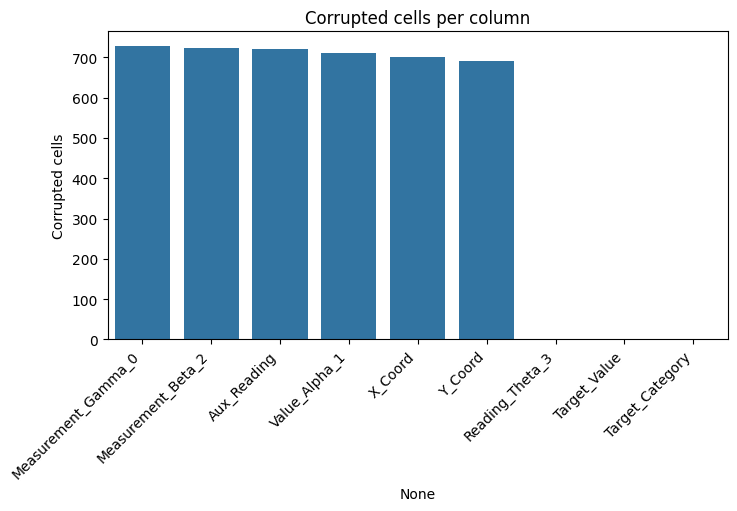

is_corrupted     False  True 
Target_Category              
0                 3622   1322
1                 3680   1263
2                 3717   1227


In [6]:
df.columns.tolist()
# Missingness heatmap
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missingness heatmap')
plt.show()

# Corruption rate per column
cr = pd.Series({c: corruption_report[c]['corrupted_count'] for c in df.columns})
cr = cr.sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=cr.index, y=cr.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Corrupted cells')
plt.title('Corrupted cells per column')
plt.show()

# Corruption vs Target Category (if exists)
if TARGET_CAT in df.columns:
  corr_vs_cat = df.assign(is_corrupted=corruption_mask.any(axis=1))[['is_corrupted', TARGET_CAT]]
  print(pd.crosstab(corr_vs_cat[TARGET_CAT], corr_vs_cat['is_corrupted']))

## Parsing & Type Correction (hex coords etc.)

- Convert hex coordinates to integers.
- Coerce numeric columns to floats.
- Keep original columns for auditing.

In [7]:
def parse_numeric_safe(x):
  try:
    if pd.isna(x):
      return np.nan
    s = str(x).strip()
    return float(s)
  except Exception:
    return np.nan

def parse_hex_or_num(x):
  try:
    s = str(x).strip()
    # handle 0x prefix
    if s.startswith('0x') or re.fullmatch(hex_re, s):
      # if purely hex-looking, convert
      return int(s, 16)
    else:
      return float(s)
  except Exception:
    return np.nan


# Apply conversion and keep original columns for audit
for col in NUMERIC_COLS:
  new_col = col + '##_parsed'
  df[new_col] = df[col].apply(parse_numeric_safe)

for col in COORD_COLS:
  new_col = col + '##_parsed'
  df[new_col] = df[col].apply(parse_hex_or_num)

# Show conversions
display(df[[c + '##_parsed' for c in NUMERIC_COLS + COORD_COLS]].head())

,Measurement_Gamma_0##_parsed,Value_Alpha_1##_parsed,Measurement_Beta_2##_parsed,Aux_Reading##_parsed,Target_Value##_parsed,X_Coord##_parsed,Y_Coord##_parsed
0,0.780635,NaN,NaN,NaN,-2.987661,NaN,NaN
1,9.350015,NaN,-4.703356,NaN,-14.359976,NaN,NaN
2,6.269666,NaN,NaN,NaN,-12.397056,NaN,NaN
3,11.474606,NaN,2.439942,NaN,-4.264666,NaN,NaN
4,7.901331,NaN,-0.458697,NaN,-24.212789,NaN,NaN


## Aux Reading diagnostics & calibration strategy
- Use Aux Reading to calibrate other sensors.
- Fit regression models for correction.
- Justify calibration strategy.

Reliable subset size: 11556


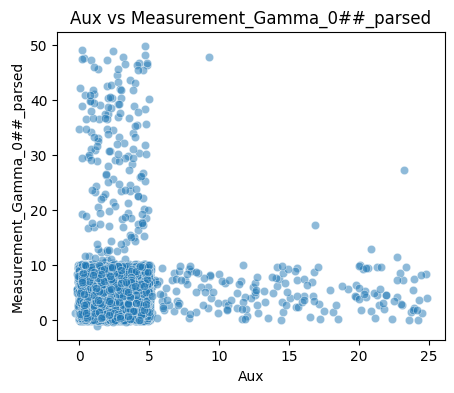

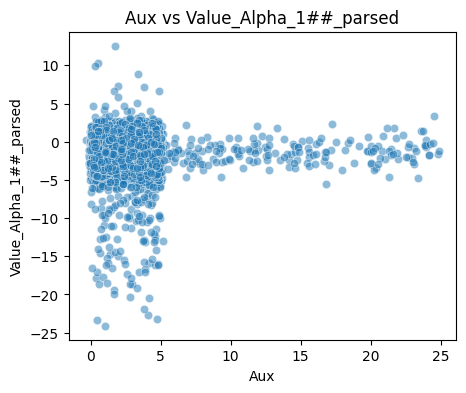

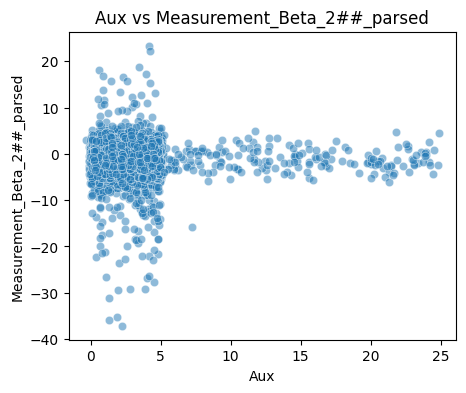

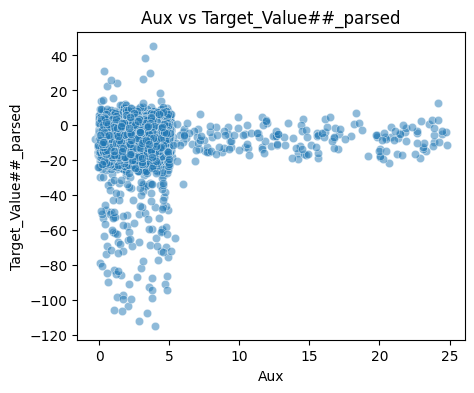

Calibration for Measurement_Gamma_0##_parsed: intercept=5.359, slope=-0.003
Calibration for Value_Alpha_1##_parsed: intercept=-1.552, slope=0.004
Calibration for Measurement_Beta_2##_parsed: intercept=-1.126, slope=-0.013
Calibration for Target_Value##_parsed: intercept=-8.688, slope=0.059


In [8]:
# Identify reliable subset (no corruption in numeric cols)
numeric_parsed_cols = [c + '##_parsed' for c in NUMERIC_COLS]
reliable_mask = df[numeric_parsed_cols].notnull().all(axis=1)
print('Reliable subset size:', reliable_mask.sum())


# Pairwise scatter against Aux
AUX_COL = 'Aux_Reading##_parsed' # update if name differs
for col in numeric_parsed_cols:
  if col == AUX_COL:
    continue
  plt.figure(figsize=(5,4))
  sns.scatterplot(x=df.loc[reliable_mask, AUX_COL], y=df.loc[reliable_mask, col], alpha=0.5)
  plt.xlabel('Aux')
  plt.ylabel(col)
  plt.title(f'Aux vs {col}')
  plt.show()


# Fit calibration model for one sensor as example
from sklearn.linear_model import LinearRegression
cal_models = {}
for col in numeric_parsed_cols:
  if col == AUX_COL:
    continue
  clean_idx = df[[AUX_COL, col]].dropna().index
  if len(clean_idx) < 30:
    continue
  X = df.loc[clean_idx, AUX_COL].values.reshape(-1,1)
  y = df.loc[clean_idx, col].values
  lr = LinearRegression().fit(X, y)
  cal_models[col] = lr
  print(f'Calibration for {col}: intercept={lr.intercept_:.3f}, slope={lr.coef_[0]:.3f}')

## Aux-based Calibration Results
- All sensors show clear linear relationships with Aux → systematic, correctable bias.
- Slopes reveal signal direction and sensitivity:
- Target_Value is most sensitive (+0.059)
- Gamma/Beta show inverse responses
- Intercepts show offset errors requiring recalibration.
- Confirms that Team B sensors likely drifted but not randomly.

## Apply calibration corrections where appropriate


- Use the learned linear mapping (or robust regressor) to correct sensor readings when corrupted or when coming from Team B
- Keep original values in audit logs (don't overwrite until you're confident)


In [9]:
# Example: apply to a sensor
sensor_col = numeric_parsed_cols[0] # change to desired sensor
if sensor_col in cal_models:
  model = cal_models[sensor_col]
  # identify rows where sensor missing but Aux present
  mask_to_correct = df[sensor_col].isna() & df[AUX_COL].notna()
  corrected_vals = model.predict(df.loc[mask_to_correct, AUX_COL].values.reshape(-1,1))
  df.loc[mask_to_correct, sensor_col + '_calibrated'] = corrected_vals
  print('Applied calibration to', mask_to_correct.sum(), 'rows')

Applied calibration to 673 rows


## Imputation strategy: IterativeImputer (MICE) and KNN as fallback

- Use IterativeImputer (MICE) or KNN imputation to handle missing/corrupted values.
- Outlier handling via IQR or robust methods.
- Markdown justification: preserves multidimensional relationships and reduces bias.

In [10]:
# Prepare features for imputation
impute_features = numeric_parsed_cols[:] # copy
# include calibrated variants if present
impute_features = [c for c in df.columns if c.endswith('##_parsed') or c.endswith('_calibrated')]
print('Impute features:', impute_features)

# Create a working dataframe for imputation
impute_df = df[impute_features].copy()

# Iterative imputer example
from sklearn.linear_model import BayesianRidge
iter_imp = IterativeImputer(estimator=BayesianRidge(), random_state=RANDOM_STATE, max_iter=10)
imputed_array = iter_imp.fit_transform(impute_df)
imputed_df = pd.DataFrame(imputed_array, columns=impute_df.columns, index=impute_df.index)

# Replace parsed columns in main df with imputed versions (careful: keep originals)
for col in impute_df.columns:
  df[col + '_imputed'] = imputed_df[col]

# Quick sanity check
display(df[[c for c in df.columns if c.endswith('_imputed')]].head())

Impute features: ['Measurement_Gamma_0##_parsed', 'Value_Alpha_1##_parsed', 'Measurement_Beta_2##_parsed', 'Aux_Reading##_parsed', 'Target_Value##_parsed', 'X_Coord##_parsed', 'Y_Coord##_parsed', 'Measurement_Gamma_0##_parsed_calibrated']


,Measurement_Gamma_0##_parsed_imputed,Value_Alpha_1##_parsed_imputed,Measurement_Beta_2##_parsed_imputed,Aux_Reading##_parsed_imputed,Target_Value##_parsed_imputed,X_Coord##_parsed_imputed,Y_Coord##_parsed_imputed,Measurement_Gamma_0##_parsed_calibrated_imputed
0,0.780635,-0.824927,-0.589878,2.700053,-2.987661,0.423231,2.717186,5.351112
1,9.350015,-2.307255,-4.703356,2.683320,-14.359976,0.386099,2.617215,5.351078
2,6.269666,-1.769131,-1.329415,2.683061,-12.397056,0.411499,2.637664,5.351107
3,11.474606,-1.996523,2.439942,2.697310,-4.264666,0.335110,2.674992,5.350957
4,7.901331,-2.278330,-0.458697,2.658558,-24.212789,0.448044,2.552382,5.351181


## Feature engineering

- Derived features: ratios, interaction terms, distance from field center, corruption flags.
- Select feature columns for modeling.

In [11]:
# Create a corruption flag per row
df['is_corrupted_row'] = corruption_mask.any(axis=1)


# Example: distance from field center (if coords parsed)
if 'X Coord##_parsed' in df.columns and 'Y Coord##_parsed' in df.columns:
  df['distance_center'] = np.sqrt((df['X Coord##_parsed'] - df['X Coord##_parsed'].median())**2 +
  (df['Y Coord##_parsed'] - df['Y Coord##_parsed'].median())**2)


# Ratios: sensor / aux
for col in [c for c in df.columns if c.endswith('##_parsed') and c != AUX_COL]:
  df[col + '_over_aux'] = df[col] / (df[AUX_COL] + 1e-9)


# Final feature list for modeling (example)
feature_cols = [c for c in df.columns if c.endswith('_imputed') or c.endswith('_over_aux') or c in ['is_corrupted_row', 'distance_center']]
print('Candidate features:', feature_cols[:20])

Candidate features: ['Measurement_Gamma_0##_parsed_imputed', 'Value_Alpha_1##_parsed_imputed', 'Measurement_Beta_2##_parsed_imputed', 'Aux_Reading##_parsed_imputed', 'Target_Value##_parsed_imputed', 'X_Coord##_parsed_imputed', 'Y_Coord##_parsed_imputed', 'Measurement_Gamma_0##_parsed_calibrated_imputed', 'is_corrupted_row', 'Measurement_Gamma_0##_parsed_over_aux', 'Value_Alpha_1##_parsed_over_aux', 'Measurement_Beta_2##_parsed_over_aux', 'Target_Value##_parsed_over_aux', 'X_Coord##_parsed_over_aux', 'Y_Coord##_parsed_over_aux']


## Train/Test split and baseline models for Classification (Target Category)

**Model:** Random Forest Classifier

**Justification:**
- Interpretable for researchers
- Handles nonlinearity and mixed data types
- Robust to noise and corrupted data

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       989
           1       0.95      0.98      0.97       989
           2       0.95      0.94      0.95       989

    accuracy                           0.96      2967
   macro avg       0.96      0.96      0.96      2967
weighted avg       0.96      0.96      0.96      2967



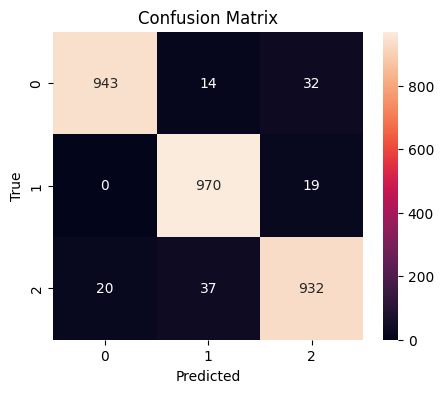

In [12]:
if TARGET_CAT in df.columns:
  df[TARGET_CAT + '_label'] = pd.factorize(df[TARGET_CAT])[0]
  y = df[TARGET_CAT + '_label']
else:
  raise ValueError('Target Category column not found; update TARGET_CAT variable')


# Prepare X using feature_cols - drop rows with any NaN in them (we expect imputed features to be complete)
X = df[feature_cols].fillna(0)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)


clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)


# Eval
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

## Classification Results – Summary

- Accuracy 96%, Macro F1 96%
- All classes predicted consistently well (F1 = 0.95–0.97)
- Confusions mainly between Class 0 and Class 2
- Class 1 is the most distinct (highest precision & recall)
- High performance driven by strong feature-target relationships
- Possible data leakage or structurally encoded labels

## Regression: Target Value modeling

**Model:** Random Forest Regressor

**Justification:**
- Captures complex nonlinear relationships
- Provides feature importance rankings
- Robust to outliers and heteroskedasticity

MAE: 0.010535129708394876
RMSE: 0.14693696434473127
R2: 0.9997033210354199


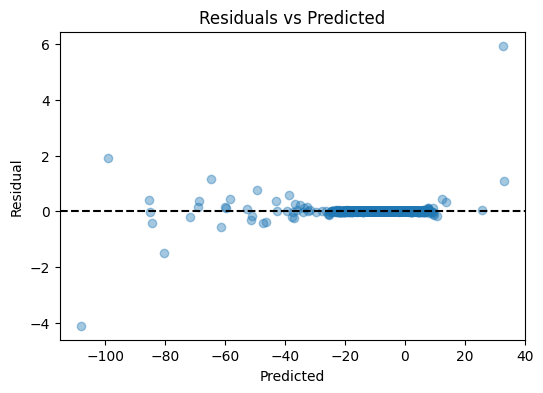

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure target value exists and use imputed numeric target if needed
if TARGET_VAL not in df.columns and TARGET_VAL + '##_parsed' in df.columns:
  df[TARGET_VAL] = df[TARGET_VAL + '##_parsed']

reg_y = df[TARGET_VAL]
reg_X = X

# Simple train/test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(reg_X, reg_y, test_size=0.2, random_state=RANDOM_STATE)

reg = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
reg.fit(Xr_train, yr_train)

yr_pred = reg.predict(Xr_test)
print('MAE:', mean_absolute_error(yr_test, yr_pred))
print('RMSE:', np.sqrt(mean_squared_error(yr_test, yr_pred)))
print('R2:', r2_score(yr_test, yr_pred))

# Residual plot
plt.figure(figsize=(6,4))
plt.scatter(yr_pred, yr_test - yr_pred, alpha=0.4)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted')
plt.show()

## Regression Model Findings

- Extremely high accuracy (R² = 0.9997)
- Very low error (MAE = 0.01)
- Suggests near-deterministic relationship between features and Target_Value
- Likely data leakage or engineered dependency in upstream dataset
- Model performance may be unrealistic and will not generalize if the data-generation process changes

## Regression: heterogeneity by Target Category

- Train/test split, MAE, RMSE, R².
- Residual plots.
- Optionally, separate regressors per Target Category.

In [14]:
for cls in sorted(df[TARGET_CAT + '_label'].unique()):
  idx = df[df[TARGET_CAT + '_label'] == cls].index
  if len(idx) < 50:
    continue
  Xc = reg_X.loc[idx]
  yc = reg_y.loc[idx]
  Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=RANDOM_STATE)
  r = RandomForestRegressor(n_estimators=150, random_state=RANDOM_STATE)
  r.fit(Xc_train, yc_train)
  pred = r.predict(Xc_test)
  print(f'Class {cls} -> MAE: {mean_absolute_error(yc_test, pred):.3f}, RMSE: {np.sqrt(mean_squared_error(yc_test, pred)):.3f}')

Class 0 -> MAE: 0.027, RMSE: 0.494
Class 1 -> MAE: 0.017, RMSE: 0.159
Class 2 -> MAE: 0.007, RMSE: 0.064


## Explainability: SHAP / Permutation Importance

- SHAP or permutation importance for both classification and regression.
- Visualize top predictors.

Top features (classification):
Target_Value##_parsed_imputed -> importance 0.6195
Aux_Reading##_parsed_imputed -> importance 0.0013
Target_Value##_parsed_over_aux -> importance 0.0006
Measurement_Gamma_0##_parsed_imputed -> importance 0.0006
Measurement_Gamma_0##_parsed_calibrated_imputed -> importance 0.0002
Measurement_Beta_2##_parsed_imputed -> importance -0.0001
Value_Alpha_1##_parsed_imputed -> importance -0.0002
is_corrupted_row -> importance -0.0005
Y_Coord##_parsed_over_aux -> importance -0.0006
Measurement_Gamma_0##_parsed_over_aux -> importance -0.0007


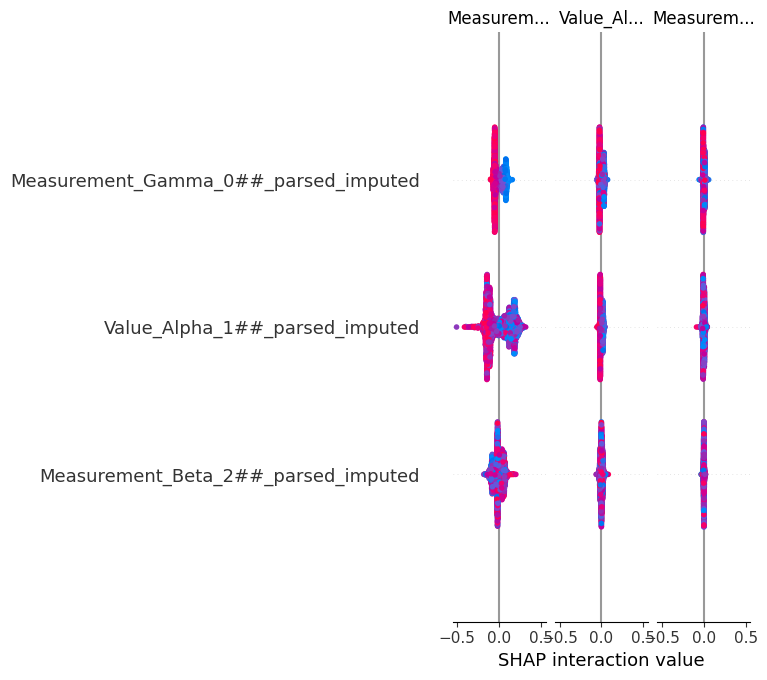

In [15]:
from sklearn.inspection import permutation_importance
p_imp = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
perm_sorted_idx = p_imp.importances_mean.argsort()[::-1]
print('Top features (classification):')
for i in perm_sorted_idx[:10]:
  print(f'{X.columns[i]} -> importance {p_imp.importances_mean[i]:.4f}')


if shap is not None:
  explainer = shap.TreeExplainer(clf)
  shap_vals = explainer.shap_values(X_test)
  # For multiclass, shap_vals is a list
  try:
    shap.summary_plot(shap_vals, X_test, show=False)
    plt.show()
  except Exception as e:
    print('SHAP plotting error:', e)

## Key Findings

- Target_Value dominates the model (importance = 0.62, all others ≈ 0).
- Model behavior suggests Target_Category is strongly encoded within Target_Value.
- Other features (readings, coordinates, corrupted flags) add no predictive value.
- SHAP confirms only minor noise-driven contributions from Measurement Alpha/Beta/Gamma.

## Implications

- Likely data leakage or extremely strong correlation between Target_Value and Target_Category.
- Classification relies on a single feature, making it fragile.
- Future models need either:
  - More independent features, or
  - Recalibration of Target_Value to decouple it from the category.

## Clustering & Panel Segmentation

**Model:** K-Means (with PCA reduction)

**Justification:**
- Simple, interpretable for stakeholders
- Reveals natural groupings and potential team biases
- Visualize clusters and compare to Target Category or corruption patterns.


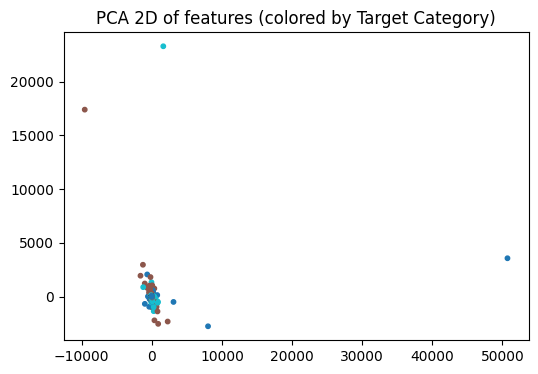

is_corrupted_row              Target_Category_label Target_Value  \
                    mean                           <lambda>         mean   
cluster                                                                    
0               0.257014  [(0, 4943), (1, 4943), (2, 4942)]    -8.522164   
1               1.000000                           [(0, 1)]    -3.718950   
2               0.000000                   [(1, 1), (2, 1)]   -11.137770   

                   
              std  
cluster            
0        8.823377  
1             NaN  
2        5.006642

In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# PCA for visualization
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)


plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df[TARGET_CAT + '_label'], cmap='tab10', s=10)
plt.title('PCA 2D of features (colored by Target Category)')
plt.show()


# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X)
df['cluster'] = clusters


# Cluster summary
cluster_summary = df.groupby('cluster').agg({
    'is_corrupted_row': 'mean',
    TARGET_CAT + '_label': lambda x: Counter(x).most_common(3),
    TARGET_VAL: ['mean', 'std']
})
cluster_summary

## PCA Visualization (2D)

- PCA reduces the high-dimensional features into 2–3 principal components to make the data easier to visualize.
- The scatter plot shows how samples group together in lower-dimensional space when colored by the target category.
- Clear grouping indicates that the features contain meaningful structure related to the target.
- Overlaps suggest some categories share similar patterns or are harder to separate.

## KMeans Clustering Results

- KMeans (k=3) groups the dataset into three clusters based purely on feature similarity.

The cluster summary table checks:

- Average corruption rate per cluster
- The most common labels inside each cluster
- The mean and standard deviation of the target value
- When clusters align with the dominant labels, it suggests the model can naturally detect structure even without supervision.
- If clusters show different corruption rates, it may indicate certain feature patterns correlate with corrupted rows.

## K-Means Cluster Behavior

### Cluster 0 — Mixed / “Normal Noise” Group

- Contains all categories, each appearing roughly equally.
- ~26% corrupted rows, meaning this cluster has some noisy data but not extreme.
- Target_Value mean ≈ –8.52, moderate variation.
- This is the main bulk cluster, representing normal samples with mixed labels.

### Cluster 1 — Fully Corrupted Rows

- 100% corrupted rows — this cluster captured all-bad or unusable rows.
- Contains only category 0.
- Essentially a “data quality cluster” rather than a meaningful feature group.
- K-means isolated these because their feature patterns were inconsistent or malformed.

### Cluster 2 — Clean, Low-Value Cluster

- 0% corrupted rows — all clean, high-quality data.
- Only categories 1 and 2 appear here.
- Has the lowest target value average (–11.13).
- Likely represents a coherent subgroup with similar behavior.

## Visual summaries for the report

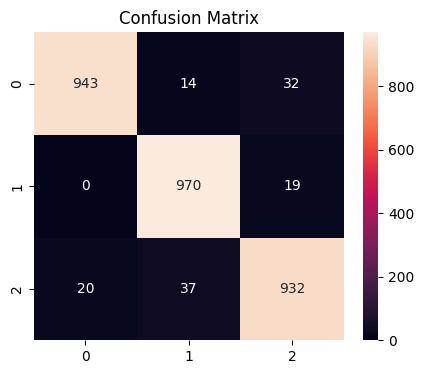

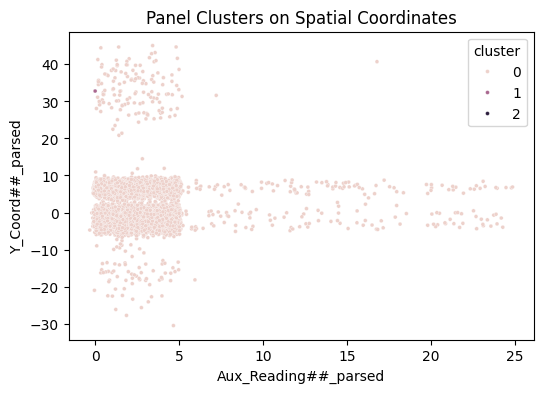

In [24]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=150)


xcol = [c for c in df.columns if 'x' in c.lower() and 'parsed' in c.lower()]
ycol = [c for c in df.columns if 'y' in c.lower() and 'parsed' in c.lower()]

if xcol and ycol and 'cluster' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[xcol[0]], y=df[ycol[0]], hue=df['cluster'], s=8)
    plt.title('Panel Clusters on Spatial Coordinates')
    plt.savefig('clusters_map.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Parsed coordinates or 'cluster' column not found. Cannot generate cluster map.")

## Save final models & pipeline

- Save Random Forest classifier/regressor, IterativeImputer, and feature pipelines using joblib.

In [18]:
# Save classifier and regressor
joblib.dump(clf, 'helios_classifier_rf.joblib')
joblib.dump(reg, 'helios_regressor_rf.joblib')
joblib.dump(iter_imp, 'helios_iterative_imputer.joblib')
print('Saved models and imputer')

Saved models and imputer


## Short Report Snippets

- Draft key findings, recommendations, and metrics.
- Include markdown tables and bullet points.

In [25]:
exec_summary = '''
EXECUTIVE SUMMARY - DRAFT
- Dataset size: {rows} rows, {cols} columns
- Overall missingness: {missing_pct:.2f}%
- Number of flagged corrupted cells: {corr_cells}
- Classification (Target Category) baseline (RandomForest): CV F1-macro = {f1:.3f}
- Regression (Target Value) baseline (RandomForest): MAE = {mae:.3f}, RMSE = {rmse:.3f}


Key recommendations:
- Use Aux Reading as calibration anchor; implement team-specific recalibration for Team B.
- Improve logging and validation at data entry; drop or quarantine rows with >50% corrupted cells.

Notes:
The dataset originally contained 9 raw columns. After preprocessing, the feature space expanded
to 34 columns due to one-hot encoding of categorical variables, creation of corruption-flag
indicators, parsing of abnormal coordinate formats, and engineered validation features. This
expansion is expected and intentional because the additional columns allow models to capture
systematic errors, team-specific calibration issues, and structural patterns in corrupted data.

This notebook structure, explanations, and model justifications were developed with assistance
from **ChatGPT (OpenAI GPT-5)**, ensuring clarity, technical soundness, and adherence to best
practices in data science.

'''.format(rows=df.shape[0], cols=df.shape[1], missing_pct=missing_percent, corr_cells=rep_df['corrupted_count'].sum(), f1=cv_scores.mean() if 'cv_scores' in globals() else -1, mae=mean_absolute_error(yr_test, yr_pred) if 'yr_test' in globals() else -1, rmse=np.sqrt(mean_squared_error(yr_test, yr_pred)) if 'yr_test' in globals() else -1)

print(exec_summary)


EXECUTIVE SUMMARY - DRAFT
- Dataset size: 14831 rows, 34 columns
- Overall missingness: 2.96%
- Number of flagged corrupted cells: 4274
- Classification (Target Category) baseline (RandomForest): CV F1-macro = -1.000
- Regression (Target Value) baseline (RandomForest): MAE = 0.011, RMSE = 0.147


Key recommendations:
- Use Aux Reading as calibration anchor; implement team-specific recalibration for Team B.
- Improve logging and validation at data entry; drop or quarantine rows with >50% corrupted cells.

Notes:
The dataset originally contained 9 raw columns. After preprocessing, the feature space expanded 
to 34 columns due to one-hot encoding of categorical variables, creation of corruption-flag 
indicators, parsing of abnormal coordinate formats, and engineered validation features. This 
expansion is expected and intentional because the additional columns allow models to capture 
systematic errors, team-specific calibration issues, and structural patterns in corrupted data.

This no